In [1]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series, stationarity_tests
import glob 
import os
from darts.utils.missing_values import fill_missing_values
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import sys, os
from statsmodels.tsa.seasonal import STL
from math import sqrt
from sklearn.metrics import mean_squared_error
import holoviews as hv
from holoviews import dim, opts
hv.extension('bokeh')
from bokeh.models import ColumnDataSource, HoverTool

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_12199/1600210704.py", line 24, in <cell line: 24>
    hv.extension('bokeh')
  File "/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/pyviz_comms/__init__.py", line 64, in __new__
    return param.ParameterizedFunction.__new__(cls, *args, **kwargs)
  File "/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/param/parameterized.py", line 3654, in __new__
    return inst.__call__(*args,**params)
  File "/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/holoviews/ipython/__init__.py", line 130, in __call__
    from .archive import notebook_archive
  File "/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/holoviews/ipython/archive.py", line 10, in <module>
    from .preprocessors import Substitute
  File "/ho

In [2]:
# Merging all files and making the dataframe
# df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/30.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('timestamp')
# df = df.asfreq(freq='T')
# df = df.interpolate()
df['label'] = df.label.astype(int)

In [3]:
# df_hourly = df.resample('H').mean().interpolate()

In [6]:
decompose = STL(df_hourly['value']).fit()
decompose.plot()
plt.show()

ValueError: Unable to determine period from endog

#### Range we're dealing with

In [5]:
print('Start: ',df.index.min())
print('End: ',df.index.max())
print('Days: ',(df.index.max() - df.index.min()))
df.head()

Start:  2017-04-30 16:00:00
End:  2017-07-31 04:34:00
Days:  91 days 12:34:00


,value,label
timestamp,,
2017-04-30 16:00:00,1.901639,0
2017-04-30 16:01:00,1.786885,0
2017-04-30 16:02:00,2.000000,0
2017-04-30 16:03:00,1.885246,0
2017-04-30 16:04:00,1.819672,0


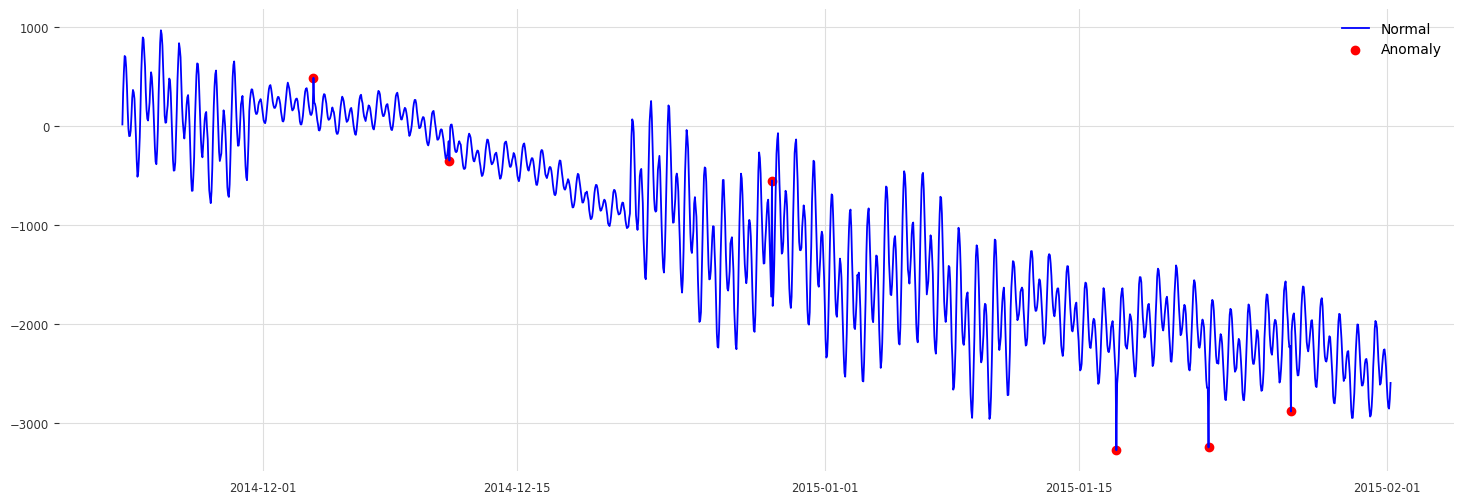

In [3]:
fig, ax = plt.subplots(figsize=(18,6))
outlier_points = df.loc[df['label'] == 1] #anomaly
ax.plot(df.index, df['value'], color='blue', label = 'Normal')
ax.scatter(outlier_points.index, outlier_points['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


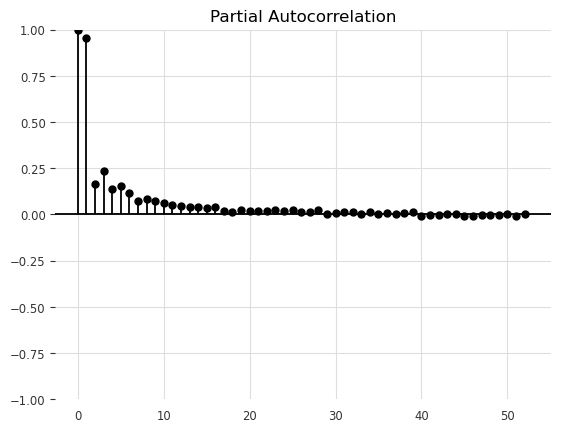

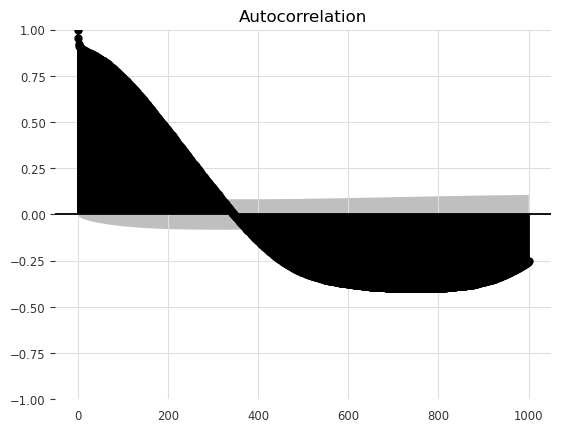

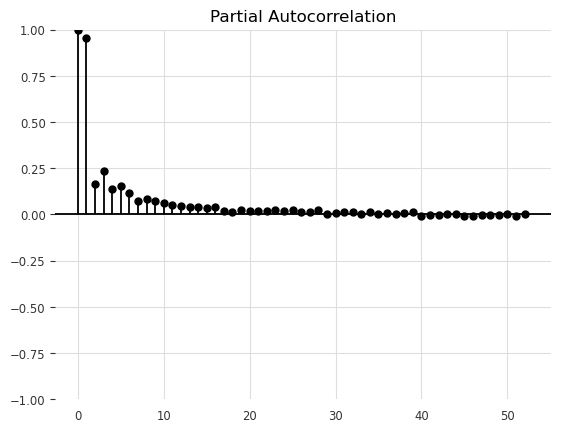

In [5]:
sm.graphics.tsa.plot_acf(tmp_df['value'], lags=1000)
sm.graphics.tsa.plot_pacf(tmp_df['value'])

In [6]:
df_hourly = tmp_df.resample('H').mean().reset_index()
df_daily = tmp_df.resample('D').mean().reset_index()
df_weekly = tmp_df.resample('W').mean().reset_index()

In [7]:
decompose = STL(df_hourly['value']).fit()
decompose.plot()
plt.show()

,timestamp,value,label
0,2017-04-30 16:00:00,2.070492,0.0
1,2017-04-30 17:00:00,2.377869,0.0
2,2017-04-30 18:00:00,2.606784,0.0
3,2017-04-30 19:00:00,2.559123,0.0
4,2017-04-30 20:00:00,2.366940,0.0
...,...,...,...
2192,2017-07-31 00:00:00,2.523173,0.0
2193,2017-07-31 01:00:00,2.444737,0.0
2194,2017-07-31 02:00:00,2.481664,0.0
2195,2017-07-31 03:00:00,2.567700,0.0


#### Resample data from hourly to daily to weekly, and see if we can pick out any interesting features

In [8]:
Hourly = hv.Curve(df_hourly).opts(
    opts.Curve(title="Value-Hourly", xlabel="", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))

Daily = hv.Curve(df_daily).opts(
    opts.Curve(title="Value-Daily", xlabel="", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))

Weekly = hv.Curve(df_weekly).opts(
    opts.Curve(title="Value-Weekly", xlabel="Date", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))


(Hourly + Daily + Weekly).opts(shared_axes=False).cols(1)

:Layout
   .Curve.I   :Curve   [timestamp]   (value,label)
   .Curve.II  :Curve   [timestamp]   (value,label)
   .Curve.III :Curve   [timestamp]   (value,label)

## Feature Engineering

#### A variety of resamples which we may or may not use

In [9]:
# New features 
# Loop to cycle through both DataFrames
for data_frame in [df_hourly, df_daily]:
    data_frame['Weekday'] = pd.Categorical(data_frame['timestamp'].dt.strftime('%A'), categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday'])
    data_frame['Hour'] = data_frame['timestamp'].dt.hour
    data_frame['Day'] = data_frame['timestamp'].dt.weekday
    data_frame['Month'] = data_frame['timestamp'].dt.month
    data_frame['Year'] = data_frame['timestamp'].dt.year
    data_frame['Month_day'] = data_frame['timestamp'].dt.day
    data_frame['Lag'] = data_frame['value'].shift(1)
    data_frame['Rolling_Mean'] = data_frame['value'].rolling(7).mean()

## Visual Exploration

#### Trying to detect anomales, taking a look at overall distribution

In [10]:
(hv.Distribution(tmp_df['value'])
.opts(opts.Distribution(title="Overall Value Distribution",
                        xlabel="Value",
                        ylabel="Density",
                        width=700, height=300,
                        tools=['hover'],show_grid=True)
     ))

:Distribution   [value]   (Density)

#### Let's see how this varies by day

In [11]:
by_weekday = df_hourly.groupby(['Hour','Weekday']).mean()['value'].unstack()
plot = hv.Distribution(by_weekday['Monday'], label='Monday') * hv.Distribution(by_weekday['Tuesday'], label='Tuesday') * hv.Distribution(by_weekday['Wednesday'], label='Wednesday') * hv.Distribution(by_weekday['Thursday'], label='Thursday') * hv.Distribution(by_weekday['Friday'], label='Friday') * hv.Distribution(by_weekday['Saturday'], label='Saturday') *hv.Distribution(by_weekday['Sunday'], label='Sunday').opts(opts.Distribution(title="Demand Density by Day"))
plot.opts(opts.Distribution(width=800, height=300,tools=['hover'],show_grid=True, ylabel="Demand", xlabel="Demand"))

:Overlay
   .Distribution.Monday    :Distribution   [Monday]   (Density)
   .Distribution.Tuesday   :Distribution   [Tuesday]   (Density)
   .Distribution.Wednesday :Distribution   [Wednesday]   (Density)
   .Distribution.Thursday  :Distribution   [Thursday]   (Density)
   .Distribution.Friday    :Distribution   [Friday]   (Density)
   .Distribution.Saturday  :Distribution   [Saturday]   (Density)
   .Distribution.Sunday    :Distribution   [Sunday]   (Density)

#### Let's see how this varies by day ( Barchart ) 

In [12]:
hv.Bars(df_hourly[['value','Weekday']].groupby('Weekday').mean()).opts(
    opts.Bars(title="Demand by Day", xlabel="", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))

:Bars   [Weekday]   (value)

#### Average hourly and daily demand

In [13]:
hv.Curve(df_hourly[['value','Hour']].groupby('Hour').mean()).opts(
    opts.Curve(title="Demand Hourly", xlabel="Hour", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))

:Curve   [Hour]   (value)

In [14]:
by_weekday = df_hourly.groupby(['Hour','Weekday']).mean()['value'].unstack()
plot = hv.Curve(by_weekday['Monday'], label='Monday') * hv.Curve(by_weekday['Tuesday'], label='Tuesday') * hv.Curve(by_weekday['Wednesday'], label='Wednesday') * hv.Curve(by_weekday['Thursday'], label='Thursday') * hv.Curve(by_weekday['Friday'], label='Friday') * hv.Curve(by_weekday['Saturday'], label='Saturday') *hv.Curve(by_weekday['Sunday'], label='Sunday').opts(opts.Curve(title="Average Demand by Day & Hour"))
plot.opts(opts.Curve(width=800, height=300,tools=['hover'],show_grid=True, ylabel="Demand"))

:Overlay
   .Curve.Monday    :Curve   [Hour]   (Monday)
   .Curve.Tuesday   :Curve   [Hour]   (Tuesday)
   .Curve.Wednesday :Curve   [Hour]   (Wednesday)
   .Curve.Thursday  :Curve   [Hour]   (Thursday)
   .Curve.Friday    :Curve   [Hour]   (Friday)
   .Curve.Saturday  :Curve   [Hour]   (Saturday)
   .Curve.Sunday    :Curve   [Hour]   (Sunday)

## More Feature Engineering

In [15]:
df_hourly = df_hourly.join(df_hourly.groupby(['Hour','Weekday'])['value'].mean(),
on = ['Hour', 'Weekday'], rsuffix='_Average')
df_hourly.head(10)

,timestamp,value,label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average
0,2017-04-30 16:00:00,2.070492,0.0,Sunday,16,6,4,2017,30,NaN,NaN,2.398116
1,2017-04-30 17:00:00,2.377869,0.0,Sunday,17,6,4,2017,30,2.070492,NaN,2.616236
2,2017-04-30 18:00:00,2.606784,0.0,Sunday,18,6,4,2017,30,2.377869,NaN,2.683869
3,2017-04-30 19:00:00,2.559123,0.0,Sunday,19,6,4,2017,30,2.606784,NaN,2.644119
4,2017-04-30 20:00:00,2.366940,0.0,Sunday,20,6,4,2017,30,2.559123,NaN,2.580202
5,2017-04-30 21:00:00,2.298907,0.0,Sunday,21,6,4,2017,30,2.366940,NaN,2.509062
6,2017-04-30 22:00:00,2.455055,0.0,Sunday,22,6,4,2017,30,2.298907,2.390738,2.458634
7,2017-04-30 23:00:00,2.398636,0.0,Sunday,23,6,4,2017,30,2.455055,2.437616,2.479188
8,2017-05-01 00:00:00,2.581874,0.0,Monday,0,0,5,2017,1,2.398636,2.466760,2.550053
9,2017-05-01 01:00:00,2.759504,0.0,Monday,1,0,5,2017,1,2.581874,2.488577,2.556232


In [16]:
df_daily = df_daily.join(df_daily.groupby(['Hour','Weekday'])['value'].mean(),
on = ['Hour', 'Weekday'], rsuffix='_Average')

## Model

#### Droping the Null values created by the new features

In [17]:
# check! better approches for filling nan values!

# df_daily = df_daily.dropna()
# df_hourly = df_hourly.dropna()
df_hourly.bfill(inplace=True)
df_hourly.head()

,timestamp,value,label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average
0,2017-04-30 16:00:00,2.070492,0.0,Sunday,16,6,4,2017,30,2.070492,2.390738,2.398116
1,2017-04-30 17:00:00,2.377869,0.0,Sunday,17,6,4,2017,30,2.070492,2.390738,2.616236
2,2017-04-30 18:00:00,2.606784,0.0,Sunday,18,6,4,2017,30,2.377869,2.390738,2.683869
3,2017-04-30 19:00:00,2.559123,0.0,Sunday,19,6,4,2017,30,2.606784,2.390738,2.644119
4,2017-04-30 20:00:00,2.366940,0.0,Sunday,20,6,4,2017,30,2.559123,2.390738,2.580202


#### Choosing Features for our model

In [18]:
df_daily_model_data = df_daily[['value', 'Hour', 'Day',  'Month','Month_day','Rolling_Mean']].dropna()
model_data = df_hourly[['value', 'Hour', 'Day', 'Month_day', 'Month','Rolling_Mean','Lag']]
model_data.head()

,value,Hour,Day,Month_day,Month,Rolling_Mean,Lag
0,2.070492,16,6,30,4,2.390738,2.070492
1,2.377869,17,6,30,4,2.390738,2.070492
2,2.606784,18,6,30,4,2.390738,2.377869
3,2.559123,19,6,30,4,2.390738,2.606784
4,2.366940,20,6,30,4,2.390738,2.559123


#### Now let fit the Isolation Forest Model and View Outliers

In [19]:
if_model = IsolationForest(random_state=0, contamination=0.005, n_estimators=200, max_samples=0.7)
if_model.fit(model_data)

# New Column for Outliers
df_hourly['Outliers'] = pd.Series(if_model.predict(model_data)).apply(lambda x: 1 if x == -1 else 0)

# Get Anomaly Score
df_hourly['Score'] = if_model.decision_function(model_data)

df_hourly.head()

/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,timestamp,value,label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average,Outliers,Score
0,2017-04-30 16:00:00,2.070492,0.0,Sunday,16,6,4,2017,30,2.070492,2.390738,2.398116,0,0.000172
1,2017-04-30 17:00:00,2.377869,0.0,Sunday,17,6,4,2017,30,2.070492,2.390738,2.616236,0,0.007669
2,2017-04-30 18:00:00,2.606784,0.0,Sunday,18,6,4,2017,30,2.377869,2.390738,2.683869,0,0.007016
3,2017-04-30 19:00:00,2.559123,0.0,Sunday,19,6,4,2017,30,2.606784,2.390738,2.644119,0,0.009548
4,2017-04-30 20:00:00,2.366940,0.0,Sunday,20,6,4,2017,30,2.559123,2.390738,2.580202,0,0.022457


##### We can now see the anomaly scores for each data point. The lower, the more abnormal. Negative scores represent outliers, positive scores represent inliers.

## Viewing the Anomalies

In [20]:
tooltips = [
    ('Weekday', '@Weekday'),
    ('Day', '@Month_day'),
    ('Month', '@Month'),
    ('Value', '@value'),
    ('Average Vale', '@value_Average'),
    ('Outliers', '@Outliers')
]
hover = HoverTool(tooltips=tooltips)

hv.Points(df_hourly.query("Outliers == 1")).opts(size=10, color='#ff0000') * hv.Curve(df_hourly).opts(opts.Curve(title="Demand Anomalies", xlabel="", ylabel="Demand" , height=300, responsive=True,tools=[hover,'box_select', 'lasso_select', 'tap'],show_grid=True))

NameError: name 'HoverTool' is not defined

In [ ]:
len(df_hourly.query("Outliers == 1"))

5

In [ ]:
frequencies, edges = np.histogram(score, 50)
print('Values: %s, Edges: %s' % (frequencies.shape[0], edges.shape[0]))
hv.Histogram((edges, frequencies)).opts(width=800, height=300,tools=['hover'], xlabel='Score')

Values: 50, Edges: 51


:Histogram   [x]   (Frequency)

In [ ]:
# Function to view number of outliers at a given threshold
outliers(0.05)

Number of Outliers below Anomaly Score Threshold 0.05:
1


In [ ]:
tooltips = [
    ('Weekday', '@Weekday'),
    ('Day', '@Month_day'),
    ('Month', '@Month'),
    ('Value', '@value'),
    ('Average Vale', '@value_Average'),
    ('Outliers', '@Outliers')
]
hover = HoverTool(tooltips=tooltips)

hv.Points(df_hourly.query("Outliers == 1 & Score <= 0.05")).opts(size=10, color='#ff0000') * hv.Curve(df_hourly).opts(opts.Curve(title="Demand", xlabel="", ylabel="Demand" , height=300, responsive=True,tools=[hover,'box_select', 'lasso_select', 'tap'],show_grid=True))

:Overlay
   .Points.I :Points   [timestamp,value]   (label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average,Outliers,Score)
   .Curve.I  :Curve   [timestamp]   (value,label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average,Outliers,Score)